In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!git clone https://github.com/eriklindernoren/PyTorch-GAN

fatal: destination path 'PyTorch-GAN' already exists and is not an empty directory.


In [2]:
%cd PyTorch-GAN

/content/PyTorch-GAN


In [3]:
!ls

assets	data  implementations  LICENSE	README.md  requirements.txt


In [4]:
pip install -r requirements.txt

In [5]:
pip install scikit-learn


In [6]:
%cd implementations/acgan

/content/PyTorch-GAN/implementations/acgan


In [8]:
#Imports required
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


In [9]:
# Create directory for generated images
os.makedirs("images", exist_ok=True)

# Argument parsing
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=50, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=256, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=16, help="number of CPU threads for data loading")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of latent space")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=200, help="interval between image sampling")

opt = parser.parse_args([])  # Modify this if passing command line arguments
print(opt)

cuda = True if torch.cuda.is_available() else False


Namespace(n_epochs=50, batch_size=256, lr=0.0002, b1=0.5, b2=0.999, n_cpu=16, latent_dim=100, n_classes=10, img_size=32, channels=1, sample_interval=200)


In [10]:
# Initialize weights
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [11]:
#Generator and Discriminator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.latent_dim)

        self.init_size = opt.img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


In [12]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)


Discriminator(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ad

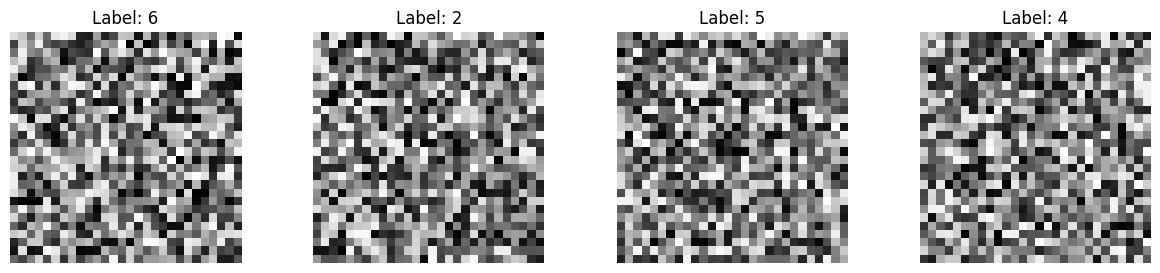

In [13]:
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class OutlierInjectedMNIST(torch.utils.data.Dataset):
    def __init__(self, dataset, outlier_fraction=0.2):
        """
        Outlier injection attack by replacing a fraction of MNIST images with random noise.

        Args:
            dataset: Original MNIST dataset.
            outlier_fraction: Fraction of dataset to replace with random noise (default: 20%).
        """
        self.dataset = dataset
        self.outlier_fraction = outlier_fraction
        self.outlier_indices = set()
        self.inject_outliers()

    def inject_outliers(self):
        """Injects random noise images as outliers into the dataset."""
        num_outliers = int(self.outlier_fraction * len(self.dataset))
        outlier_indices = np.random.choice(len(self.dataset), num_outliers, replace=False)
        self.outlier_indices = set(outlier_indices)

        for idx in outlier_indices:
            # Generate a completely random noise image
            random_image = torch.randn((1, 28, 28))  # MNIST has 1 channel, 28x28 size

            # Assign a random label (not necessarily related to real digits)
            random_label = np.random.randint(0, 10)

            # Replace original sample with outlier
            self.dataset.data[idx] = (random_image * 255).byte()  # Convert to same format as MNIST
            self.dataset.targets[idx] = random_label

    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

# Load original MNIST dataset
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

# Apply outlier injection attack (e.g., 20% of images replaced with random noise)
poisoned_dataset = OutlierInjectedMNIST(dataset, outlier_fraction=0.2)

# Visualizing the injected outliers
def visualize_outliers(dataset, num_samples=4):
    """Displays random outliers from the dataset."""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i, idx in enumerate(np.random.choice(list(dataset.outlier_indices), num_samples, replace=False)):
        img, label = dataset[idx]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

# Visualize some injected outliers
visualize_outliers(poisoned_dataset)


In [14]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def sample_image(n_row, batches_done, poisoned=False):
    """Saves a grid of generated digits"""
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    filename = f"images/{'poisoned_' if poisoned else ''}{batches_done}.png"
    save_image(gen_imgs.data, filename, nrow=n_row, normalize=True)


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Track metrics
g_losses, d_losses, d_accuracies = [], [], []
epoch_confusion_matrices = []

# --- Training Loop ---
for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.size(0)

        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # Train Generator
        optimizer_G.zero_grad()
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))
        gen_imgs = generator(z, gen_labels)
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2
        d_loss = (d_real_loss + d_fake_loss) / 2

        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)
        d_loss.backward()
        optimizer_D.step()

        # Store metrics for visualization
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        d_accuracies.append(d_acc * 100)

        if i == len(dataloader) - 1:
            cm = confusion_matrix(gt, np.argmax(pred, axis=1))
            epoch_confusion_matrices.append(cm)

        print(
            f"[Epoch {epoch}/{opt.n_epochs}] [Batch {i}/{len(dataloader)}] "
            f"[D loss: {d_loss.item():.6f}, acc: {100 * d_acc:.2f}%] [G loss: {g_loss.item():.6f}]"
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done, poisoned=True)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 0/50] [Batch 0/235] [D loss: 1.497982, acc: 7.62%] [G loss: 1.504045]
[Epoch 0/50] [Batch 1/235] [D loss: 1.497895, acc: 10.74%] [G loss: 1.503683]
[Epoch 0/50] [Batch 2/235] [D loss: 1.497840, acc: 12.50%] [G loss: 1.503546]
[Epoch 0/50] [Batch 3/235] [D loss: 1.497847, acc: 8.79%] [G loss: 1.503210]
[Epoch 0/50] [Batch 4/235] [D loss: 1.497911, acc: 10.16%] [G loss: 1.503076]
[Epoch 0/50] [Batch 5/235] [D loss: 1.497803, acc: 9.57%] [G loss: 1.502865]
[Epoch 0/50] [Batch 6/235] [D loss: 1.497653, acc: 12.70%] [G loss: 1.502428]
[Epoch 0/50] [Batch 7/235] [D loss: 1.497649, acc: 9.38%] [G loss: 1.502184]
[Epoch 0/50] [Batch 8/235] [D loss: 1.497640, acc: 7.81%] [G loss: 1.501942]
[Epoch 0/50] [Batch 9/235] [D loss: 1.497527, acc: 9.77%] [G loss: 1.501649]
[Epoch 0/50] [Batch 10/235] [D loss: 1.497529, acc: 9.18%] [G loss: 1.501358]
[Epoch 0/50] [Batch 11/235] [D loss: 1.497440, acc: 11.52%] [G loss: 1.500876]
[Epoch 0/50] [Batch 12/235] [D loss: 1.497261, acc: 9.57%] [G loss: 1

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 1/50] [Batch 1/235] [D loss: 1.451954, acc: 23.05%] [G loss: 1.530496]
[Epoch 1/50] [Batch 2/235] [D loss: 1.444430, acc: 20.31%] [G loss: 1.550360]
[Epoch 1/50] [Batch 3/235] [D loss: 1.442197, acc: 18.36%] [G loss: 1.568809]
[Epoch 1/50] [Batch 4/235] [D loss: 1.446880, acc: 19.53%] [G loss: 1.525480]
[Epoch 1/50] [Batch 5/235] [D loss: 1.468586, acc: 20.70%] [G loss: 1.492573]
[Epoch 1/50] [Batch 6/235] [D loss: 1.485496, acc: 20.51%] [G loss: 1.456311]
[Epoch 1/50] [Batch 7/235] [D loss: 1.487626, acc: 23.44%] [G loss: 1.446900]
[Epoch 1/50] [Batch 8/235] [D loss: 1.495195, acc: 21.68%] [G loss: 1.434644]
[Epoch 1/50] [Batch 9/235] [D loss: 1.492473, acc: 23.24%] [G loss: 1.442223]
[Epoch 1/50] [Batch 10/235] [D loss: 1.483540, acc: 22.07%] [G loss: 1.436080]
[Epoch 1/50] [Batch 11/235] [D loss: 1.463400, acc: 22.27%] [G loss: 1.449886]
[Epoch 1/50] [Batch 12/235] [D loss: 1.469784, acc: 22.27%] [G loss: 1.458345]
[Epoch 1/50] [Batch 13/235] [D loss: 1.455183, acc: 21.68%] [

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 2/50] [Batch 1/235] [D loss: 1.312712, acc: 48.24%] [G loss: 1.455630]
[Epoch 2/50] [Batch 2/235] [D loss: 1.304760, acc: 50.00%] [G loss: 1.451487]
[Epoch 2/50] [Batch 3/235] [D loss: 1.293179, acc: 51.56%] [G loss: 1.410725]
[Epoch 2/50] [Batch 4/235] [D loss: 1.307432, acc: 50.00%] [G loss: 1.417553]
[Epoch 2/50] [Batch 5/235] [D loss: 1.287976, acc: 54.49%] [G loss: 1.387951]
[Epoch 2/50] [Batch 6/235] [D loss: 1.285886, acc: 53.91%] [G loss: 1.395772]
[Epoch 2/50] [Batch 7/235] [D loss: 1.271707, acc: 57.42%] [G loss: 1.372927]
[Epoch 2/50] [Batch 8/235] [D loss: 1.296631, acc: 52.15%] [G loss: 1.398365]
[Epoch 2/50] [Batch 9/235] [D loss: 1.311848, acc: 49.41%] [G loss: 1.420412]
[Epoch 2/50] [Batch 10/235] [D loss: 1.289036, acc: 53.32%] [G loss: 1.417856]
[Epoch 2/50] [Batch 11/235] [D loss: 1.317664, acc: 49.41%] [G loss: 1.385152]
[Epoch 2/50] [Batch 12/235] [D loss: 1.297987, acc: 54.69%] [G loss: 1.384028]
[Epoch 2/50] [Batch 13/235] [D loss: 1.301513, acc: 55.27%] [

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 3/50] [Batch 0/235] [D loss: 1.167634, acc: 71.68%] [G loss: 1.343274]
[Epoch 3/50] [Batch 1/235] [D loss: 1.170442, acc: 72.27%] [G loss: 1.290784]
[Epoch 3/50] [Batch 2/235] [D loss: 1.170672, acc: 73.24%] [G loss: 1.295967]
[Epoch 3/50] [Batch 3/235] [D loss: 1.206447, acc: 69.53%] [G loss: 1.293578]
[Epoch 3/50] [Batch 4/235] [D loss: 1.197951, acc: 69.14%] [G loss: 1.277296]
[Epoch 3/50] [Batch 5/235] [D loss: 1.224832, acc: 67.58%] [G loss: 1.259603]
[Epoch 3/50] [Batch 6/235] [D loss: 1.183467, acc: 70.51%] [G loss: 1.350967]
[Epoch 3/50] [Batch 7/235] [D loss: 1.203139, acc: 66.99%] [G loss: 1.322352]
[Epoch 3/50] [Batch 8/235] [D loss: 1.187877, acc: 70.90%] [G loss: 1.277138]
[Epoch 3/50] [Batch 9/235] [D loss: 1.182785, acc: 71.88%] [G loss: 1.227102]
[Epoch 3/50] [Batch 10/235] [D loss: 1.191110, acc: 67.97%] [G loss: 1.308046]
[Epoch 3/50] [Batch 11/235] [D loss: 1.183648, acc: 72.85%] [G loss: 1.253359]
[Epoch 3/50] [Batch 12/235] [D loss: 1.188086, acc: 70.70%] [G

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 4/50] [Batch 0/235] [D loss: 1.167230, acc: 74.80%] [G loss: 1.306162]
[Epoch 4/50] [Batch 1/235] [D loss: 1.181896, acc: 72.07%] [G loss: 1.241380]
[Epoch 4/50] [Batch 2/235] [D loss: 1.168005, acc: 73.63%] [G loss: 1.258069]
[Epoch 4/50] [Batch 3/235] [D loss: 1.145558, acc: 75.39%] [G loss: 1.343199]
[Epoch 4/50] [Batch 4/235] [D loss: 1.173095, acc: 70.51%] [G loss: 1.283134]
[Epoch 4/50] [Batch 5/235] [D loss: 1.182806, acc: 69.92%] [G loss: 1.285342]
[Epoch 4/50] [Batch 6/235] [D loss: 1.152770, acc: 76.76%] [G loss: 1.292359]
[Epoch 4/50] [Batch 7/235] [D loss: 1.166896, acc: 72.66%] [G loss: 1.349830]
[Epoch 4/50] [Batch 8/235] [D loss: 1.157301, acc: 75.00%] [G loss: 1.248143]
[Epoch 4/50] [Batch 9/235] [D loss: 1.174857, acc: 72.07%] [G loss: 1.251006]
[Epoch 4/50] [Batch 10/235] [D loss: 1.203937, acc: 70.90%] [G loss: 1.290177]
[Epoch 4/50] [Batch 11/235] [D loss: 1.159982, acc: 72.85%] [G loss: 1.290510]
[Epoch 4/50] [Batch 12/235] [D loss: 1.131775, acc: 76.17%] [G

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 5/50] [Batch 1/235] [D loss: 1.144831, acc: 75.00%] [G loss: 1.290854]
[Epoch 5/50] [Batch 2/235] [D loss: 1.156024, acc: 75.78%] [G loss: 1.191374]
[Epoch 5/50] [Batch 3/235] [D loss: 1.133116, acc: 76.37%] [G loss: 1.346521]
[Epoch 5/50] [Batch 4/235] [D loss: 1.144652, acc: 75.39%] [G loss: 1.343985]
[Epoch 5/50] [Batch 5/235] [D loss: 1.162254, acc: 71.48%] [G loss: 1.360233]
[Epoch 5/50] [Batch 6/235] [D loss: 1.154652, acc: 76.95%] [G loss: 1.230633]
[Epoch 5/50] [Batch 7/235] [D loss: 1.179229, acc: 74.41%] [G loss: 1.298260]
[Epoch 5/50] [Batch 8/235] [D loss: 1.164258, acc: 74.02%] [G loss: 1.247443]
[Epoch 5/50] [Batch 9/235] [D loss: 1.185523, acc: 75.78%] [G loss: 1.286717]
[Epoch 5/50] [Batch 10/235] [D loss: 1.182504, acc: 74.41%] [G loss: 1.200191]
[Epoch 5/50] [Batch 11/235] [D loss: 1.181833, acc: 73.44%] [G loss: 1.346734]
[Epoch 5/50] [Batch 12/235] [D loss: 1.154681, acc: 75.78%] [G loss: 1.287069]
[Epoch 5/50] [Batch 13/235] [D loss: 1.201005, acc: 75.98%] [

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 6/50] [Batch 1/235] [D loss: 1.128369, acc: 80.08%] [G loss: 1.226777]
[Epoch 6/50] [Batch 2/235] [D loss: 1.143033, acc: 75.98%] [G loss: 1.368346]
[Epoch 6/50] [Batch 3/235] [D loss: 1.155257, acc: 76.37%] [G loss: 1.372810]
[Epoch 6/50] [Batch 4/235] [D loss: 1.131243, acc: 75.78%] [G loss: 1.307586]
[Epoch 6/50] [Batch 5/235] [D loss: 1.148369, acc: 74.41%] [G loss: 1.303523]
[Epoch 6/50] [Batch 6/235] [D loss: 1.145789, acc: 75.39%] [G loss: 1.280464]
[Epoch 6/50] [Batch 7/235] [D loss: 1.162983, acc: 71.88%] [G loss: 1.505076]
[Epoch 6/50] [Batch 8/235] [D loss: 1.192515, acc: 73.83%] [G loss: 1.304017]
[Epoch 6/50] [Batch 9/235] [D loss: 1.101310, acc: 74.61%] [G loss: 1.337119]
[Epoch 6/50] [Batch 10/235] [D loss: 1.116386, acc: 76.76%] [G loss: 1.278239]
[Epoch 6/50] [Batch 11/235] [D loss: 1.161969, acc: 77.34%] [G loss: 1.378471]
[Epoch 6/50] [Batch 12/235] [D loss: 1.161112, acc: 77.34%] [G loss: 1.348331]
[Epoch 6/50] [Batch 13/235] [D loss: 1.147107, acc: 74.80%] [

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 7/50] [Batch 1/235] [D loss: 1.157752, acc: 78.91%] [G loss: 1.268564]
[Epoch 7/50] [Batch 2/235] [D loss: 1.148605, acc: 78.12%] [G loss: 1.452183]
[Epoch 7/50] [Batch 3/235] [D loss: 1.137234, acc: 74.22%] [G loss: 1.229642]
[Epoch 7/50] [Batch 4/235] [D loss: 1.138668, acc: 76.56%] [G loss: 1.300382]
[Epoch 7/50] [Batch 5/235] [D loss: 1.141763, acc: 75.20%] [G loss: 1.362778]
[Epoch 7/50] [Batch 6/235] [D loss: 1.165224, acc: 78.71%] [G loss: 1.200272]
[Epoch 7/50] [Batch 7/235] [D loss: 1.100870, acc: 79.30%] [G loss: 1.234319]
[Epoch 7/50] [Batch 8/235] [D loss: 1.126956, acc: 75.59%] [G loss: 1.365931]
[Epoch 7/50] [Batch 9/235] [D loss: 1.150785, acc: 75.78%] [G loss: 1.355269]
[Epoch 7/50] [Batch 10/235] [D loss: 1.162551, acc: 73.83%] [G loss: 1.365686]
[Epoch 7/50] [Batch 11/235] [D loss: 1.138811, acc: 77.73%] [G loss: 1.355567]
[Epoch 7/50] [Batch 12/235] [D loss: 1.137117, acc: 77.15%] [G loss: 1.175074]
[Epoch 7/50] [Batch 13/235] [D loss: 1.105395, acc: 78.12%] [

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 8/50] [Batch 1/235] [D loss: 1.167729, acc: 74.41%] [G loss: 1.087658]
[Epoch 8/50] [Batch 2/235] [D loss: 1.165549, acc: 75.20%] [G loss: 1.312310]
[Epoch 8/50] [Batch 3/235] [D loss: 1.147374, acc: 78.71%] [G loss: 1.412153]
[Epoch 8/50] [Batch 4/235] [D loss: 1.127043, acc: 77.15%] [G loss: 1.365811]
[Epoch 8/50] [Batch 5/235] [D loss: 1.135854, acc: 74.02%] [G loss: 1.251012]
[Epoch 8/50] [Batch 6/235] [D loss: 1.130057, acc: 72.85%] [G loss: 1.397421]
[Epoch 8/50] [Batch 7/235] [D loss: 1.143178, acc: 74.61%] [G loss: 1.363111]
[Epoch 8/50] [Batch 8/235] [D loss: 1.087496, acc: 78.12%] [G loss: 1.245400]
[Epoch 8/50] [Batch 9/235] [D loss: 1.109805, acc: 77.73%] [G loss: 1.259159]
[Epoch 8/50] [Batch 10/235] [D loss: 1.126150, acc: 76.56%] [G loss: 1.388049]
[Epoch 8/50] [Batch 11/235] [D loss: 1.121012, acc: 77.15%] [G loss: 1.286540]
[Epoch 8/50] [Batch 12/235] [D loss: 1.119504, acc: 76.95%] [G loss: 1.396374]
[Epoch 8/50] [Batch 13/235] [D loss: 1.199650, acc: 75.39%] [

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 9/50] [Batch 0/235] [D loss: 1.124529, acc: 81.25%] [G loss: 1.165262]
[Epoch 9/50] [Batch 1/235] [D loss: 1.113547, acc: 83.01%] [G loss: 1.186132]
[Epoch 9/50] [Batch 2/235] [D loss: 1.095641, acc: 79.88%] [G loss: 1.266986]
[Epoch 9/50] [Batch 3/235] [D loss: 1.101267, acc: 81.45%] [G loss: 1.271020]
[Epoch 9/50] [Batch 4/235] [D loss: 1.105148, acc: 79.10%] [G loss: 1.240276]
[Epoch 9/50] [Batch 5/235] [D loss: 1.140908, acc: 79.30%] [G loss: 1.155365]
[Epoch 9/50] [Batch 6/235] [D loss: 1.117457, acc: 79.88%] [G loss: 1.245690]
[Epoch 9/50] [Batch 7/235] [D loss: 1.154331, acc: 79.10%] [G loss: 1.141962]
[Epoch 9/50] [Batch 8/235] [D loss: 1.100668, acc: 81.84%] [G loss: 1.218046]
[Epoch 9/50] [Batch 9/235] [D loss: 1.061677, acc: 83.40%] [G loss: 1.334958]
[Epoch 9/50] [Batch 10/235] [D loss: 1.103132, acc: 84.77%] [G loss: 1.381827]
[Epoch 9/50] [Batch 11/235] [D loss: 1.143745, acc: 83.59%] [G loss: 1.133978]
[Epoch 9/50] [Batch 12/235] [D loss: 1.143761, acc: 80.66%] [G

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 10/50] [Batch 0/235] [D loss: 1.128204, acc: 82.03%] [G loss: 1.278601]
[Epoch 10/50] [Batch 1/235] [D loss: 1.127359, acc: 81.45%] [G loss: 1.164536]
[Epoch 10/50] [Batch 2/235] [D loss: 1.124558, acc: 84.77%] [G loss: 1.307227]
[Epoch 10/50] [Batch 3/235] [D loss: 1.132620, acc: 81.45%] [G loss: 1.394431]
[Epoch 10/50] [Batch 4/235] [D loss: 1.107018, acc: 82.62%] [G loss: 1.213032]
[Epoch 10/50] [Batch 5/235] [D loss: 1.105624, acc: 80.66%] [G loss: 1.220829]
[Epoch 10/50] [Batch 6/235] [D loss: 1.106762, acc: 85.35%] [G loss: 1.252492]
[Epoch 10/50] [Batch 7/235] [D loss: 1.132113, acc: 84.18%] [G loss: 1.283740]
[Epoch 10/50] [Batch 8/235] [D loss: 1.108882, acc: 79.88%] [G loss: 1.205051]
[Epoch 10/50] [Batch 9/235] [D loss: 1.121126, acc: 84.77%] [G loss: 1.271979]
[Epoch 10/50] [Batch 10/235] [D loss: 1.118359, acc: 81.84%] [G loss: 1.321152]
[Epoch 10/50] [Batch 11/235] [D loss: 1.143162, acc: 79.69%] [G loss: 1.215371]
[Epoch 10/50] [Batch 12/235] [D loss: 1.118150, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 11/50] [Batch 0/235] [D loss: 1.141996, acc: 82.42%] [G loss: 1.108068]
[Epoch 11/50] [Batch 1/235] [D loss: 1.104740, acc: 85.35%] [G loss: 1.078124]
[Epoch 11/50] [Batch 2/235] [D loss: 1.104372, acc: 83.40%] [G loss: 1.294921]
[Epoch 11/50] [Batch 3/235] [D loss: 1.091099, acc: 83.59%] [G loss: 1.429430]
[Epoch 11/50] [Batch 4/235] [D loss: 1.127053, acc: 81.84%] [G loss: 1.133854]
[Epoch 11/50] [Batch 5/235] [D loss: 1.128607, acc: 84.96%] [G loss: 1.256637]
[Epoch 11/50] [Batch 6/235] [D loss: 1.135302, acc: 84.38%] [G loss: 1.368242]
[Epoch 11/50] [Batch 7/235] [D loss: 1.098781, acc: 83.59%] [G loss: 1.335501]
[Epoch 11/50] [Batch 8/235] [D loss: 1.106276, acc: 85.16%] [G loss: 1.320568]
[Epoch 11/50] [Batch 9/235] [D loss: 1.173341, acc: 81.05%] [G loss: 1.074597]
[Epoch 11/50] [Batch 10/235] [D loss: 1.091335, acc: 82.42%] [G loss: 1.213333]
[Epoch 11/50] [Batch 11/235] [D loss: 1.127005, acc: 85.35%] [G loss: 1.331519]
[Epoch 11/50] [Batch 12/235] [D loss: 1.146719, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 12/50] [Batch 1/235] [D loss: 1.106492, acc: 85.35%] [G loss: 1.117539]
[Epoch 12/50] [Batch 2/235] [D loss: 1.145050, acc: 83.40%] [G loss: 1.298417]
[Epoch 12/50] [Batch 3/235] [D loss: 1.087171, acc: 83.79%] [G loss: 1.384347]
[Epoch 12/50] [Batch 4/235] [D loss: 1.100555, acc: 83.98%] [G loss: 1.331138]
[Epoch 12/50] [Batch 5/235] [D loss: 1.103475, acc: 87.50%] [G loss: 1.151132]
[Epoch 12/50] [Batch 6/235] [D loss: 1.103907, acc: 85.94%] [G loss: 1.149661]
[Epoch 12/50] [Batch 7/235] [D loss: 1.073364, acc: 84.38%] [G loss: 1.077037]
[Epoch 12/50] [Batch 8/235] [D loss: 1.052517, acc: 87.89%] [G loss: 1.277031]
[Epoch 12/50] [Batch 9/235] [D loss: 1.136103, acc: 85.16%] [G loss: 1.269809]
[Epoch 12/50] [Batch 10/235] [D loss: 1.113579, acc: 80.66%] [G loss: 1.096061]
[Epoch 12/50] [Batch 11/235] [D loss: 1.066440, acc: 85.94%] [G loss: 1.129113]
[Epoch 12/50] [Batch 12/235] [D loss: 1.118637, acc: 85.55%] [G loss: 1.214103]
[Epoch 12/50] [Batch 13/235] [D loss: 1.089318, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 13/50] [Batch 0/235] [D loss: 1.112612, acc: 83.40%] [G loss: 1.257316]
[Epoch 13/50] [Batch 1/235] [D loss: 1.073960, acc: 85.94%] [G loss: 1.212746]
[Epoch 13/50] [Batch 2/235] [D loss: 1.090915, acc: 86.13%] [G loss: 1.198545]
[Epoch 13/50] [Batch 3/235] [D loss: 1.131363, acc: 85.35%] [G loss: 1.136914]
[Epoch 13/50] [Batch 4/235] [D loss: 1.135679, acc: 84.77%] [G loss: 1.230807]
[Epoch 13/50] [Batch 5/235] [D loss: 1.096168, acc: 81.84%] [G loss: 1.197797]
[Epoch 13/50] [Batch 6/235] [D loss: 1.142229, acc: 81.84%] [G loss: 1.223027]
[Epoch 13/50] [Batch 7/235] [D loss: 1.134098, acc: 83.40%] [G loss: 1.199498]
[Epoch 13/50] [Batch 8/235] [D loss: 1.125533, acc: 84.77%] [G loss: 1.315428]
[Epoch 13/50] [Batch 9/235] [D loss: 1.087870, acc: 84.77%] [G loss: 1.282388]
[Epoch 13/50] [Batch 10/235] [D loss: 1.168594, acc: 84.38%] [G loss: 1.117227]
[Epoch 13/50] [Batch 11/235] [D loss: 1.106131, acc: 84.38%] [G loss: 1.379728]
[Epoch 13/50] [Batch 12/235] [D loss: 1.176172, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 14/50] [Batch 1/235] [D loss: 1.110955, acc: 85.74%] [G loss: 1.160820]
[Epoch 14/50] [Batch 2/235] [D loss: 1.121898, acc: 84.77%] [G loss: 1.252294]
[Epoch 14/50] [Batch 3/235] [D loss: 1.141230, acc: 86.52%] [G loss: 1.130774]
[Epoch 14/50] [Batch 4/235] [D loss: 1.095058, acc: 85.35%] [G loss: 1.274947]
[Epoch 14/50] [Batch 5/235] [D loss: 1.164693, acc: 83.79%] [G loss: 1.243295]
[Epoch 14/50] [Batch 6/235] [D loss: 1.121401, acc: 83.98%] [G loss: 1.284768]
[Epoch 14/50] [Batch 7/235] [D loss: 1.094606, acc: 85.55%] [G loss: 1.315454]
[Epoch 14/50] [Batch 8/235] [D loss: 1.099804, acc: 83.98%] [G loss: 1.247760]
[Epoch 14/50] [Batch 9/235] [D loss: 1.127710, acc: 84.77%] [G loss: 1.265387]
[Epoch 14/50] [Batch 10/235] [D loss: 1.182216, acc: 83.40%] [G loss: 1.108889]
[Epoch 14/50] [Batch 11/235] [D loss: 1.138598, acc: 83.40%] [G loss: 1.181813]
[Epoch 14/50] [Batch 12/235] [D loss: 1.125628, acc: 85.35%] [G loss: 1.351507]
[Epoch 14/50] [Batch 13/235] [D loss: 1.141189, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 15/50] [Batch 1/235] [D loss: 1.111271, acc: 86.13%] [G loss: 1.201507]
[Epoch 15/50] [Batch 2/235] [D loss: 1.165800, acc: 82.03%] [G loss: 1.276807]
[Epoch 15/50] [Batch 3/235] [D loss: 1.127192, acc: 83.40%] [G loss: 1.241570]
[Epoch 15/50] [Batch 4/235] [D loss: 1.103871, acc: 85.35%] [G loss: 1.088036]
[Epoch 15/50] [Batch 5/235] [D loss: 1.159471, acc: 83.40%] [G loss: 1.181207]
[Epoch 15/50] [Batch 6/235] [D loss: 1.080045, acc: 86.33%] [G loss: 1.201950]
[Epoch 15/50] [Batch 7/235] [D loss: 1.152679, acc: 84.38%] [G loss: 1.271359]
[Epoch 15/50] [Batch 8/235] [D loss: 1.115542, acc: 83.59%] [G loss: 1.147821]
[Epoch 15/50] [Batch 9/235] [D loss: 1.148017, acc: 86.13%] [G loss: 1.202394]
[Epoch 15/50] [Batch 10/235] [D loss: 1.157625, acc: 83.01%] [G loss: 1.185506]
[Epoch 15/50] [Batch 11/235] [D loss: 1.106483, acc: 86.52%] [G loss: 1.239036]
[Epoch 15/50] [Batch 12/235] [D loss: 1.129091, acc: 84.77%] [G loss: 1.328552]
[Epoch 15/50] [Batch 13/235] [D loss: 1.111317, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 16/50] [Batch 1/235] [D loss: 1.120562, acc: 84.77%] [G loss: 1.162282]
[Epoch 16/50] [Batch 2/235] [D loss: 1.092721, acc: 86.52%] [G loss: 1.150699]
[Epoch 16/50] [Batch 3/235] [D loss: 1.156506, acc: 84.77%] [G loss: 1.218830]
[Epoch 16/50] [Batch 4/235] [D loss: 1.121321, acc: 84.57%] [G loss: 1.294737]
[Epoch 16/50] [Batch 5/235] [D loss: 1.057012, acc: 85.74%] [G loss: 1.182490]
[Epoch 16/50] [Batch 6/235] [D loss: 1.119642, acc: 83.79%] [G loss: 1.114660]
[Epoch 16/50] [Batch 7/235] [D loss: 1.138197, acc: 86.72%] [G loss: 1.098037]
[Epoch 16/50] [Batch 8/235] [D loss: 1.092808, acc: 84.38%] [G loss: 1.176925]
[Epoch 16/50] [Batch 9/235] [D loss: 1.172785, acc: 82.03%] [G loss: 1.355586]
[Epoch 16/50] [Batch 10/235] [D loss: 1.104284, acc: 85.55%] [G loss: 1.190546]
[Epoch 16/50] [Batch 11/235] [D loss: 1.196539, acc: 84.57%] [G loss: 1.271296]
[Epoch 16/50] [Batch 12/235] [D loss: 1.136360, acc: 84.57%] [G loss: 1.153201]
[Epoch 16/50] [Batch 13/235] [D loss: 1.160245, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 17/50] [Batch 0/235] [D loss: 1.089645, acc: 82.81%] [G loss: 1.161296]
[Epoch 17/50] [Batch 1/235] [D loss: 1.146851, acc: 81.64%] [G loss: 1.145574]
[Epoch 17/50] [Batch 2/235] [D loss: 1.125959, acc: 81.45%] [G loss: 1.359841]
[Epoch 17/50] [Batch 3/235] [D loss: 1.129366, acc: 84.38%] [G loss: 1.245072]
[Epoch 17/50] [Batch 4/235] [D loss: 1.192281, acc: 84.18%] [G loss: 1.066347]
[Epoch 17/50] [Batch 5/235] [D loss: 1.106035, acc: 84.18%] [G loss: 1.247633]
[Epoch 17/50] [Batch 6/235] [D loss: 1.122439, acc: 86.91%] [G loss: 1.215345]
[Epoch 17/50] [Batch 7/235] [D loss: 1.126276, acc: 84.77%] [G loss: 1.098641]
[Epoch 17/50] [Batch 8/235] [D loss: 1.130964, acc: 84.38%] [G loss: 1.179119]
[Epoch 17/50] [Batch 9/235] [D loss: 1.108695, acc: 85.35%] [G loss: 1.144945]
[Epoch 17/50] [Batch 10/235] [D loss: 1.160754, acc: 87.30%] [G loss: 1.278375]
[Epoch 17/50] [Batch 11/235] [D loss: 1.126827, acc: 84.96%] [G loss: 1.115966]
[Epoch 17/50] [Batch 12/235] [D loss: 1.121319, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 18/50] [Batch 1/235] [D loss: 1.065279, acc: 88.09%] [G loss: 1.235741]
[Epoch 18/50] [Batch 2/235] [D loss: 1.129440, acc: 85.16%] [G loss: 1.206293]
[Epoch 18/50] [Batch 3/235] [D loss: 1.115270, acc: 82.23%] [G loss: 1.286019]
[Epoch 18/50] [Batch 4/235] [D loss: 1.143948, acc: 83.20%] [G loss: 1.152978]
[Epoch 18/50] [Batch 5/235] [D loss: 1.132344, acc: 87.50%] [G loss: 1.194673]
[Epoch 18/50] [Batch 6/235] [D loss: 1.126905, acc: 87.11%] [G loss: 1.122458]
[Epoch 18/50] [Batch 7/235] [D loss: 1.113593, acc: 85.94%] [G loss: 1.137983]
[Epoch 18/50] [Batch 8/235] [D loss: 1.125178, acc: 88.48%] [G loss: 1.319842]
[Epoch 18/50] [Batch 9/235] [D loss: 1.144885, acc: 86.72%] [G loss: 1.147651]
[Epoch 18/50] [Batch 10/235] [D loss: 1.113174, acc: 85.35%] [G loss: 1.139356]
[Epoch 18/50] [Batch 11/235] [D loss: 1.125179, acc: 84.38%] [G loss: 1.224372]
[Epoch 18/50] [Batch 12/235] [D loss: 1.095678, acc: 86.91%] [G loss: 1.179625]
[Epoch 18/50] [Batch 13/235] [D loss: 1.071984, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 19/50] [Batch 0/235] [D loss: 1.132341, acc: 88.09%] [G loss: 1.087723]
[Epoch 19/50] [Batch 1/235] [D loss: 1.114125, acc: 84.18%] [G loss: 1.131457]
[Epoch 19/50] [Batch 2/235] [D loss: 1.123263, acc: 86.52%] [G loss: 1.199724]
[Epoch 19/50] [Batch 3/235] [D loss: 1.148744, acc: 86.33%] [G loss: 1.147683]
[Epoch 19/50] [Batch 4/235] [D loss: 1.094426, acc: 86.33%] [G loss: 1.247091]
[Epoch 19/50] [Batch 5/235] [D loss: 1.124526, acc: 84.57%] [G loss: 1.102246]
[Epoch 19/50] [Batch 6/235] [D loss: 1.148456, acc: 84.77%] [G loss: 1.132593]
[Epoch 19/50] [Batch 7/235] [D loss: 1.165543, acc: 85.74%] [G loss: 1.270462]
[Epoch 19/50] [Batch 8/235] [D loss: 1.116025, acc: 85.16%] [G loss: 1.198912]
[Epoch 19/50] [Batch 9/235] [D loss: 1.123976, acc: 88.09%] [G loss: 1.132837]
[Epoch 19/50] [Batch 10/235] [D loss: 1.104321, acc: 86.52%] [G loss: 1.116681]
[Epoch 19/50] [Batch 11/235] [D loss: 1.162231, acc: 84.18%] [G loss: 1.240662]
[Epoch 19/50] [Batch 12/235] [D loss: 1.217533, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 20/50] [Batch 1/235] [D loss: 1.082232, acc: 86.33%] [G loss: 1.209180]
[Epoch 20/50] [Batch 2/235] [D loss: 1.106302, acc: 85.16%] [G loss: 1.207093]
[Epoch 20/50] [Batch 3/235] [D loss: 1.048550, acc: 86.13%] [G loss: 1.141152]
[Epoch 20/50] [Batch 4/235] [D loss: 1.153392, acc: 88.67%] [G loss: 1.046684]
[Epoch 20/50] [Batch 5/235] [D loss: 1.080487, acc: 88.28%] [G loss: 1.113887]
[Epoch 20/50] [Batch 6/235] [D loss: 1.069294, acc: 84.77%] [G loss: 1.164180]
[Epoch 20/50] [Batch 7/235] [D loss: 1.119070, acc: 89.06%] [G loss: 1.126721]
[Epoch 20/50] [Batch 8/235] [D loss: 1.123852, acc: 85.35%] [G loss: 1.208720]
[Epoch 20/50] [Batch 9/235] [D loss: 1.109645, acc: 86.52%] [G loss: 1.214203]
[Epoch 20/50] [Batch 10/235] [D loss: 1.127565, acc: 86.52%] [G loss: 1.186697]
[Epoch 20/50] [Batch 11/235] [D loss: 1.165793, acc: 85.35%] [G loss: 1.326317]
[Epoch 20/50] [Batch 12/235] [D loss: 1.082704, acc: 84.96%] [G loss: 1.122762]
[Epoch 20/50] [Batch 13/235] [D loss: 1.135138, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 21/50] [Batch 1/235] [D loss: 1.147161, acc: 86.52%] [G loss: 1.136312]
[Epoch 21/50] [Batch 2/235] [D loss: 1.115477, acc: 83.20%] [G loss: 1.293877]
[Epoch 21/50] [Batch 3/235] [D loss: 1.114076, acc: 88.48%] [G loss: 1.176876]
[Epoch 21/50] [Batch 4/235] [D loss: 1.148409, acc: 86.52%] [G loss: 1.258641]
[Epoch 21/50] [Batch 5/235] [D loss: 1.102319, acc: 85.94%] [G loss: 1.208853]
[Epoch 21/50] [Batch 6/235] [D loss: 1.110023, acc: 86.52%] [G loss: 0.987669]
[Epoch 21/50] [Batch 7/235] [D loss: 1.179848, acc: 86.52%] [G loss: 1.155878]
[Epoch 21/50] [Batch 8/235] [D loss: 1.142396, acc: 88.67%] [G loss: 1.296080]
[Epoch 21/50] [Batch 9/235] [D loss: 1.170209, acc: 85.74%] [G loss: 1.154465]
[Epoch 21/50] [Batch 10/235] [D loss: 1.174244, acc: 83.59%] [G loss: 1.106077]
[Epoch 21/50] [Batch 11/235] [D loss: 1.146284, acc: 83.20%] [G loss: 1.165291]
[Epoch 21/50] [Batch 12/235] [D loss: 1.157702, acc: 85.55%] [G loss: 1.307420]
[Epoch 21/50] [Batch 13/235] [D loss: 1.123931, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 22/50] [Batch 1/235] [D loss: 1.095543, acc: 85.74%] [G loss: 1.123930]
[Epoch 22/50] [Batch 2/235] [D loss: 1.149074, acc: 89.06%] [G loss: 1.149790]
[Epoch 22/50] [Batch 3/235] [D loss: 1.087303, acc: 83.98%] [G loss: 1.212961]
[Epoch 22/50] [Batch 4/235] [D loss: 1.112295, acc: 85.94%] [G loss: 1.152056]
[Epoch 22/50] [Batch 5/235] [D loss: 1.117694, acc: 87.11%] [G loss: 1.122479]
[Epoch 22/50] [Batch 6/235] [D loss: 1.112432, acc: 85.35%] [G loss: 1.263939]
[Epoch 22/50] [Batch 7/235] [D loss: 1.103939, acc: 84.57%] [G loss: 1.209847]
[Epoch 22/50] [Batch 8/235] [D loss: 1.119692, acc: 84.96%] [G loss: 1.256361]
[Epoch 22/50] [Batch 9/235] [D loss: 1.156125, acc: 89.26%] [G loss: 1.114787]
[Epoch 22/50] [Batch 10/235] [D loss: 1.040136, acc: 89.65%] [G loss: 1.227347]
[Epoch 22/50] [Batch 11/235] [D loss: 1.100419, acc: 85.94%] [G loss: 1.376659]
[Epoch 22/50] [Batch 12/235] [D loss: 1.129539, acc: 85.74%] [G loss: 1.135491]
[Epoch 22/50] [Batch 13/235] [D loss: 1.058491, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 23/50] [Batch 0/235] [D loss: 1.128610, acc: 87.30%] [G loss: 1.163011]
[Epoch 23/50] [Batch 1/235] [D loss: 1.134430, acc: 85.35%] [G loss: 1.102150]
[Epoch 23/50] [Batch 2/235] [D loss: 1.134530, acc: 84.57%] [G loss: 1.161189]
[Epoch 23/50] [Batch 3/235] [D loss: 1.106098, acc: 89.06%] [G loss: 1.205369]
[Epoch 23/50] [Batch 4/235] [D loss: 1.115365, acc: 83.98%] [G loss: 1.208271]
[Epoch 23/50] [Batch 5/235] [D loss: 1.103549, acc: 86.13%] [G loss: 1.053622]
[Epoch 23/50] [Batch 6/235] [D loss: 1.071553, acc: 85.94%] [G loss: 1.378820]
[Epoch 23/50] [Batch 7/235] [D loss: 1.091988, acc: 85.94%] [G loss: 1.191583]
[Epoch 23/50] [Batch 8/235] [D loss: 1.088702, acc: 84.18%] [G loss: 1.101007]
[Epoch 23/50] [Batch 9/235] [D loss: 1.110623, acc: 87.89%] [G loss: 1.149908]
[Epoch 23/50] [Batch 10/235] [D loss: 1.162835, acc: 85.94%] [G loss: 1.249590]
[Epoch 23/50] [Batch 11/235] [D loss: 1.119426, acc: 87.50%] [G loss: 1.218353]
[Epoch 23/50] [Batch 12/235] [D loss: 1.125053, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 24/50] [Batch 1/235] [D loss: 1.117970, acc: 86.33%] [G loss: 1.187132]
[Epoch 24/50] [Batch 2/235] [D loss: 1.106109, acc: 85.94%] [G loss: 1.305396]
[Epoch 24/50] [Batch 3/235] [D loss: 1.161015, acc: 88.48%] [G loss: 1.108975]
[Epoch 24/50] [Batch 4/235] [D loss: 1.121063, acc: 86.33%] [G loss: 1.062042]
[Epoch 24/50] [Batch 5/235] [D loss: 1.106292, acc: 85.74%] [G loss: 1.200726]
[Epoch 24/50] [Batch 6/235] [D loss: 1.138845, acc: 86.91%] [G loss: 1.234164]
[Epoch 24/50] [Batch 7/235] [D loss: 1.125020, acc: 87.30%] [G loss: 1.168518]
[Epoch 24/50] [Batch 8/235] [D loss: 1.106837, acc: 82.62%] [G loss: 1.136939]
[Epoch 24/50] [Batch 9/235] [D loss: 1.066421, acc: 87.30%] [G loss: 1.164999]
[Epoch 24/50] [Batch 10/235] [D loss: 1.184775, acc: 87.11%] [G loss: 1.282152]
[Epoch 24/50] [Batch 11/235] [D loss: 1.109686, acc: 88.87%] [G loss: 1.180564]
[Epoch 24/50] [Batch 12/235] [D loss: 1.122446, acc: 85.74%] [G loss: 1.300681]
[Epoch 24/50] [Batch 13/235] [D loss: 1.132971, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 25/50] [Batch 0/235] [D loss: 1.158867, acc: 86.33%] [G loss: 1.184700]
[Epoch 25/50] [Batch 1/235] [D loss: 1.136742, acc: 86.91%] [G loss: 1.053931]
[Epoch 25/50] [Batch 2/235] [D loss: 1.145485, acc: 84.38%] [G loss: 1.151189]
[Epoch 25/50] [Batch 3/235] [D loss: 1.071872, acc: 86.72%] [G loss: 1.170444]
[Epoch 25/50] [Batch 4/235] [D loss: 1.149226, acc: 85.35%] [G loss: 1.184328]
[Epoch 25/50] [Batch 5/235] [D loss: 1.100276, acc: 84.77%] [G loss: 1.196141]
[Epoch 25/50] [Batch 6/235] [D loss: 1.142634, acc: 85.16%] [G loss: 1.157212]
[Epoch 25/50] [Batch 7/235] [D loss: 1.104275, acc: 85.94%] [G loss: 1.125643]
[Epoch 25/50] [Batch 8/235] [D loss: 1.091445, acc: 87.89%] [G loss: 1.220179]
[Epoch 25/50] [Batch 9/235] [D loss: 1.162802, acc: 88.28%] [G loss: 1.151592]
[Epoch 25/50] [Batch 10/235] [D loss: 1.090597, acc: 88.28%] [G loss: 1.245281]
[Epoch 25/50] [Batch 11/235] [D loss: 1.159577, acc: 88.87%] [G loss: 1.194543]
[Epoch 25/50] [Batch 12/235] [D loss: 1.107128, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 26/50] [Batch 0/235] [D loss: 1.108467, acc: 86.52%] [G loss: 1.385392]
[Epoch 26/50] [Batch 1/235] [D loss: 1.091467, acc: 85.16%] [G loss: 1.237796]
[Epoch 26/50] [Batch 2/235] [D loss: 1.153061, acc: 85.55%] [G loss: 1.148556]
[Epoch 26/50] [Batch 3/235] [D loss: 1.081720, acc: 85.16%] [G loss: 1.058609]
[Epoch 26/50] [Batch 4/235] [D loss: 1.146249, acc: 85.55%] [G loss: 1.276855]
[Epoch 26/50] [Batch 5/235] [D loss: 1.068716, acc: 89.06%] [G loss: 1.191842]
[Epoch 26/50] [Batch 6/235] [D loss: 1.118820, acc: 86.52%] [G loss: 1.191902]
[Epoch 26/50] [Batch 7/235] [D loss: 1.075301, acc: 87.70%] [G loss: 1.025524]
[Epoch 26/50] [Batch 8/235] [D loss: 1.123017, acc: 87.70%] [G loss: 1.223160]
[Epoch 26/50] [Batch 9/235] [D loss: 1.111785, acc: 86.91%] [G loss: 1.168507]
[Epoch 26/50] [Batch 10/235] [D loss: 1.201598, acc: 85.94%] [G loss: 1.271492]
[Epoch 26/50] [Batch 11/235] [D loss: 1.200922, acc: 88.67%] [G loss: 1.160122]
[Epoch 26/50] [Batch 12/235] [D loss: 1.140720, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 27/50] [Batch 1/235] [D loss: 1.085024, acc: 86.13%] [G loss: 1.117837]
[Epoch 27/50] [Batch 2/235] [D loss: 1.094816, acc: 89.45%] [G loss: 1.165733]
[Epoch 27/50] [Batch 3/235] [D loss: 1.099513, acc: 85.74%] [G loss: 1.226032]
[Epoch 27/50] [Batch 4/235] [D loss: 1.090711, acc: 86.72%] [G loss: 1.045621]
[Epoch 27/50] [Batch 5/235] [D loss: 1.145142, acc: 84.57%] [G loss: 1.055639]
[Epoch 27/50] [Batch 6/235] [D loss: 1.146301, acc: 85.74%] [G loss: 1.100393]
[Epoch 27/50] [Batch 7/235] [D loss: 1.074989, acc: 86.52%] [G loss: 1.358872]
[Epoch 27/50] [Batch 8/235] [D loss: 1.158672, acc: 86.13%] [G loss: 1.361637]
[Epoch 27/50] [Batch 9/235] [D loss: 1.140327, acc: 84.38%] [G loss: 1.137566]
[Epoch 27/50] [Batch 10/235] [D loss: 1.095481, acc: 86.91%] [G loss: 1.044996]
[Epoch 27/50] [Batch 11/235] [D loss: 1.114809, acc: 86.13%] [G loss: 1.080366]
[Epoch 27/50] [Batch 12/235] [D loss: 1.178019, acc: 84.96%] [G loss: 1.154699]
[Epoch 27/50] [Batch 13/235] [D loss: 1.156565, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 28/50] [Batch 0/235] [D loss: 1.117728, acc: 87.50%] [G loss: 1.211658]
[Epoch 28/50] [Batch 1/235] [D loss: 1.120044, acc: 85.35%] [G loss: 1.180161]
[Epoch 28/50] [Batch 2/235] [D loss: 1.145768, acc: 89.84%] [G loss: 1.084493]
[Epoch 28/50] [Batch 3/235] [D loss: 1.096234, acc: 85.35%] [G loss: 1.097838]
[Epoch 28/50] [Batch 4/235] [D loss: 1.088759, acc: 88.67%] [G loss: 1.263440]
[Epoch 28/50] [Batch 5/235] [D loss: 1.121818, acc: 85.35%] [G loss: 1.231377]
[Epoch 28/50] [Batch 6/235] [D loss: 1.159687, acc: 87.30%] [G loss: 1.303525]
[Epoch 28/50] [Batch 7/235] [D loss: 1.096128, acc: 88.28%] [G loss: 1.051071]
[Epoch 28/50] [Batch 8/235] [D loss: 1.051456, acc: 86.72%] [G loss: 1.353528]
[Epoch 28/50] [Batch 9/235] [D loss: 1.127328, acc: 87.30%] [G loss: 1.159806]
[Epoch 28/50] [Batch 10/235] [D loss: 1.084221, acc: 85.55%] [G loss: 1.056557]
[Epoch 28/50] [Batch 11/235] [D loss: 1.124440, acc: 86.52%] [G loss: 1.263514]
[Epoch 28/50] [Batch 12/235] [D loss: 1.091109, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 29/50] [Batch 0/235] [D loss: 1.136958, acc: 86.13%] [G loss: 1.462824]
[Epoch 29/50] [Batch 1/235] [D loss: 1.079027, acc: 88.09%] [G loss: 1.154165]
[Epoch 29/50] [Batch 2/235] [D loss: 1.127815, acc: 84.38%] [G loss: 0.986647]
[Epoch 29/50] [Batch 3/235] [D loss: 1.118211, acc: 85.35%] [G loss: 1.071082]
[Epoch 29/50] [Batch 4/235] [D loss: 1.192604, acc: 85.74%] [G loss: 1.324424]
[Epoch 29/50] [Batch 5/235] [D loss: 1.129095, acc: 91.02%] [G loss: 1.188610]
[Epoch 29/50] [Batch 6/235] [D loss: 1.139642, acc: 87.50%] [G loss: 1.096545]
[Epoch 29/50] [Batch 7/235] [D loss: 1.144108, acc: 84.77%] [G loss: 1.108242]
[Epoch 29/50] [Batch 8/235] [D loss: 1.127309, acc: 87.70%] [G loss: 1.093957]
[Epoch 29/50] [Batch 9/235] [D loss: 1.084829, acc: 87.70%] [G loss: 1.110786]
[Epoch 29/50] [Batch 10/235] [D loss: 1.110079, acc: 85.74%] [G loss: 1.207311]
[Epoch 29/50] [Batch 11/235] [D loss: 1.139337, acc: 84.96%] [G loss: 1.063853]
[Epoch 29/50] [Batch 12/235] [D loss: 1.128380, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 30/50] [Batch 1/235] [D loss: 1.078805, acc: 86.72%] [G loss: 1.146499]
[Epoch 30/50] [Batch 2/235] [D loss: 1.114657, acc: 85.16%] [G loss: 1.150714]
[Epoch 30/50] [Batch 3/235] [D loss: 1.103404, acc: 86.91%] [G loss: 1.231855]
[Epoch 30/50] [Batch 4/235] [D loss: 1.140521, acc: 86.52%] [G loss: 1.133222]
[Epoch 30/50] [Batch 5/235] [D loss: 1.074423, acc: 89.26%] [G loss: 1.152261]
[Epoch 30/50] [Batch 6/235] [D loss: 1.136796, acc: 89.45%] [G loss: 1.090857]
[Epoch 30/50] [Batch 7/235] [D loss: 1.073630, acc: 85.55%] [G loss: 1.193455]
[Epoch 30/50] [Batch 8/235] [D loss: 1.096290, acc: 89.26%] [G loss: 1.198653]
[Epoch 30/50] [Batch 9/235] [D loss: 1.154921, acc: 84.96%] [G loss: 1.181197]
[Epoch 30/50] [Batch 10/235] [D loss: 1.103083, acc: 85.94%] [G loss: 1.335144]
[Epoch 30/50] [Batch 11/235] [D loss: 1.097310, acc: 86.13%] [G loss: 1.087907]
[Epoch 30/50] [Batch 12/235] [D loss: 1.118784, acc: 88.67%] [G loss: 1.043435]
[Epoch 30/50] [Batch 13/235] [D loss: 1.124824, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 31/50] [Batch 0/235] [D loss: 1.130125, acc: 86.91%] [G loss: 1.037452]
[Epoch 31/50] [Batch 1/235] [D loss: 1.049824, acc: 89.65%] [G loss: 1.227923]
[Epoch 31/50] [Batch 2/235] [D loss: 1.150390, acc: 88.48%] [G loss: 1.217340]
[Epoch 31/50] [Batch 3/235] [D loss: 1.135881, acc: 87.89%] [G loss: 1.130237]
[Epoch 31/50] [Batch 4/235] [D loss: 1.126974, acc: 84.57%] [G loss: 1.221601]
[Epoch 31/50] [Batch 5/235] [D loss: 1.164732, acc: 84.38%] [G loss: 1.004031]
[Epoch 31/50] [Batch 6/235] [D loss: 1.106988, acc: 87.30%] [G loss: 1.159307]
[Epoch 31/50] [Batch 7/235] [D loss: 1.098142, acc: 87.70%] [G loss: 1.105333]
[Epoch 31/50] [Batch 8/235] [D loss: 1.098525, acc: 88.67%] [G loss: 1.127072]
[Epoch 31/50] [Batch 9/235] [D loss: 1.149145, acc: 88.28%] [G loss: 1.011192]
[Epoch 31/50] [Batch 10/235] [D loss: 1.133989, acc: 86.13%] [G loss: 1.143631]
[Epoch 31/50] [Batch 11/235] [D loss: 1.104268, acc: 87.50%] [G loss: 1.306137]
[Epoch 31/50] [Batch 12/235] [D loss: 1.105320, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 32/50] [Batch 0/235] [D loss: 1.126040, acc: 87.30%] [G loss: 1.252347]
[Epoch 32/50] [Batch 1/235] [D loss: 1.153748, acc: 88.28%] [G loss: 1.308281]
[Epoch 32/50] [Batch 2/235] [D loss: 1.068510, acc: 86.13%] [G loss: 1.130438]
[Epoch 32/50] [Batch 3/235] [D loss: 1.111233, acc: 86.72%] [G loss: 1.150092]
[Epoch 32/50] [Batch 4/235] [D loss: 1.122274, acc: 86.33%] [G loss: 1.082283]
[Epoch 32/50] [Batch 5/235] [D loss: 1.124903, acc: 85.55%] [G loss: 1.179242]
[Epoch 32/50] [Batch 6/235] [D loss: 1.113572, acc: 86.91%] [G loss: 1.159722]
[Epoch 32/50] [Batch 7/235] [D loss: 1.153054, acc: 83.98%] [G loss: 1.105770]
[Epoch 32/50] [Batch 8/235] [D loss: 1.124570, acc: 89.26%] [G loss: 1.111279]
[Epoch 32/50] [Batch 9/235] [D loss: 1.115139, acc: 87.89%] [G loss: 1.123641]
[Epoch 32/50] [Batch 10/235] [D loss: 1.107298, acc: 84.96%] [G loss: 1.144343]
[Epoch 32/50] [Batch 11/235] [D loss: 1.071478, acc: 88.28%] [G loss: 1.159613]
[Epoch 32/50] [Batch 12/235] [D loss: 1.086021, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 33/50] [Batch 0/235] [D loss: 1.094974, acc: 88.28%] [G loss: 1.242118]
[Epoch 33/50] [Batch 1/235] [D loss: 1.129036, acc: 89.06%] [G loss: 1.153843]
[Epoch 33/50] [Batch 2/235] [D loss: 1.153032, acc: 85.94%] [G loss: 1.061154]
[Epoch 33/50] [Batch 3/235] [D loss: 1.141136, acc: 85.94%] [G loss: 1.171375]
[Epoch 33/50] [Batch 4/235] [D loss: 1.134250, acc: 88.87%] [G loss: 1.306318]
[Epoch 33/50] [Batch 5/235] [D loss: 1.105591, acc: 88.09%] [G loss: 1.239981]
[Epoch 33/50] [Batch 6/235] [D loss: 1.194847, acc: 86.91%] [G loss: 1.157034]
[Epoch 33/50] [Batch 7/235] [D loss: 1.078960, acc: 89.26%] [G loss: 1.136820]
[Epoch 33/50] [Batch 8/235] [D loss: 1.122112, acc: 86.13%] [G loss: 1.128932]
[Epoch 33/50] [Batch 9/235] [D loss: 1.131641, acc: 86.33%] [G loss: 1.109025]
[Epoch 33/50] [Batch 10/235] [D loss: 1.075000, acc: 89.06%] [G loss: 1.210426]
[Epoch 33/50] [Batch 11/235] [D loss: 1.128761, acc: 87.30%] [G loss: 1.253848]
[Epoch 33/50] [Batch 12/235] [D loss: 1.130776, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 34/50] [Batch 1/235] [D loss: 1.099268, acc: 88.48%] [G loss: 1.132805]
[Epoch 34/50] [Batch 2/235] [D loss: 1.076794, acc: 88.09%] [G loss: 1.118906]
[Epoch 34/50] [Batch 3/235] [D loss: 1.146583, acc: 87.89%] [G loss: 1.142453]
[Epoch 34/50] [Batch 4/235] [D loss: 1.158193, acc: 86.52%] [G loss: 1.134280]
[Epoch 34/50] [Batch 5/235] [D loss: 1.112532, acc: 86.52%] [G loss: 1.072259]
[Epoch 34/50] [Batch 6/235] [D loss: 1.132414, acc: 86.72%] [G loss: 1.194353]
[Epoch 34/50] [Batch 7/235] [D loss: 1.075418, acc: 86.72%] [G loss: 1.182762]
[Epoch 34/50] [Batch 8/235] [D loss: 1.078177, acc: 89.65%] [G loss: 1.099554]
[Epoch 34/50] [Batch 9/235] [D loss: 1.127224, acc: 87.70%] [G loss: 1.060494]
[Epoch 34/50] [Batch 10/235] [D loss: 1.068965, acc: 88.09%] [G loss: 1.099182]
[Epoch 34/50] [Batch 11/235] [D loss: 1.165105, acc: 85.35%] [G loss: 1.049161]
[Epoch 34/50] [Batch 12/235] [D loss: 1.120669, acc: 87.11%] [G loss: 1.242534]
[Epoch 34/50] [Batch 13/235] [D loss: 1.110597, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 35/50] [Batch 1/235] [D loss: 1.080442, acc: 86.72%] [G loss: 1.113500]
[Epoch 35/50] [Batch 2/235] [D loss: 1.125752, acc: 86.91%] [G loss: 1.238305]
[Epoch 35/50] [Batch 3/235] [D loss: 1.133943, acc: 88.09%] [G loss: 1.192142]
[Epoch 35/50] [Batch 4/235] [D loss: 1.156751, acc: 88.09%] [G loss: 1.185419]
[Epoch 35/50] [Batch 5/235] [D loss: 1.173827, acc: 89.06%] [G loss: 1.421652]
[Epoch 35/50] [Batch 6/235] [D loss: 1.114917, acc: 87.11%] [G loss: 1.106332]
[Epoch 35/50] [Batch 7/235] [D loss: 1.140181, acc: 87.89%] [G loss: 1.077317]
[Epoch 35/50] [Batch 8/235] [D loss: 1.061817, acc: 88.09%] [G loss: 1.095719]
[Epoch 35/50] [Batch 9/235] [D loss: 1.077299, acc: 87.11%] [G loss: 1.087941]
[Epoch 35/50] [Batch 10/235] [D loss: 1.098329, acc: 87.50%] [G loss: 1.100618]
[Epoch 35/50] [Batch 11/235] [D loss: 1.129883, acc: 83.40%] [G loss: 1.164875]
[Epoch 35/50] [Batch 12/235] [D loss: 1.115987, acc: 84.96%] [G loss: 1.226258]
[Epoch 35/50] [Batch 13/235] [D loss: 1.117189, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 36/50] [Batch 0/235] [D loss: 1.142893, acc: 88.48%] [G loss: 1.203488]
[Epoch 36/50] [Batch 1/235] [D loss: 1.153197, acc: 87.89%] [G loss: 1.101770]
[Epoch 36/50] [Batch 2/235] [D loss: 1.089373, acc: 86.52%] [G loss: 1.118547]
[Epoch 36/50] [Batch 3/235] [D loss: 1.094679, acc: 87.50%] [G loss: 1.135360]
[Epoch 36/50] [Batch 4/235] [D loss: 1.200755, acc: 86.33%] [G loss: 1.104504]
[Epoch 36/50] [Batch 5/235] [D loss: 1.138180, acc: 88.67%] [G loss: 1.078027]
[Epoch 36/50] [Batch 6/235] [D loss: 1.149150, acc: 86.72%] [G loss: 1.210229]
[Epoch 36/50] [Batch 7/235] [D loss: 1.085729, acc: 88.09%] [G loss: 1.394431]
[Epoch 36/50] [Batch 8/235] [D loss: 1.148816, acc: 84.38%] [G loss: 1.090823]
[Epoch 36/50] [Batch 9/235] [D loss: 1.073795, acc: 87.70%] [G loss: 1.154747]
[Epoch 36/50] [Batch 10/235] [D loss: 1.104377, acc: 86.33%] [G loss: 1.196419]
[Epoch 36/50] [Batch 11/235] [D loss: 1.083799, acc: 88.09%] [G loss: 1.145007]
[Epoch 36/50] [Batch 12/235] [D loss: 1.107865, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 37/50] [Batch 0/235] [D loss: 1.088709, acc: 87.89%] [G loss: 1.116051]
[Epoch 37/50] [Batch 1/235] [D loss: 1.095039, acc: 85.94%] [G loss: 1.307469]
[Epoch 37/50] [Batch 2/235] [D loss: 1.087947, acc: 88.09%] [G loss: 1.113904]
[Epoch 37/50] [Batch 3/235] [D loss: 1.115516, acc: 86.13%] [G loss: 1.201989]
[Epoch 37/50] [Batch 4/235] [D loss: 1.138656, acc: 87.70%] [G loss: 1.152558]
[Epoch 37/50] [Batch 5/235] [D loss: 1.122865, acc: 85.55%] [G loss: 1.296825]
[Epoch 37/50] [Batch 6/235] [D loss: 1.102280, acc: 87.30%] [G loss: 1.363702]
[Epoch 37/50] [Batch 7/235] [D loss: 1.061476, acc: 85.94%] [G loss: 1.193813]
[Epoch 37/50] [Batch 8/235] [D loss: 1.099600, acc: 87.50%] [G loss: 1.066592]
[Epoch 37/50] [Batch 9/235] [D loss: 1.138314, acc: 86.33%] [G loss: 1.117009]
[Epoch 37/50] [Batch 10/235] [D loss: 1.177682, acc: 85.94%] [G loss: 1.044030]
[Epoch 37/50] [Batch 11/235] [D loss: 1.092140, acc: 87.70%] [G loss: 1.116506]
[Epoch 37/50] [Batch 12/235] [D loss: 1.095634, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 38/50] [Batch 1/235] [D loss: 1.149722, acc: 89.45%] [G loss: 1.055170]
[Epoch 38/50] [Batch 2/235] [D loss: 1.085107, acc: 85.16%] [G loss: 1.235823]
[Epoch 38/50] [Batch 3/235] [D loss: 1.221587, acc: 86.52%] [G loss: 1.181351]
[Epoch 38/50] [Batch 4/235] [D loss: 1.113470, acc: 88.67%] [G loss: 1.032645]
[Epoch 38/50] [Batch 5/235] [D loss: 1.099280, acc: 86.52%] [G loss: 1.148108]
[Epoch 38/50] [Batch 6/235] [D loss: 1.052782, acc: 88.87%] [G loss: 1.195448]
[Epoch 38/50] [Batch 7/235] [D loss: 1.169080, acc: 90.04%] [G loss: 1.053392]
[Epoch 38/50] [Batch 8/235] [D loss: 1.172419, acc: 88.67%] [G loss: 1.304140]
[Epoch 38/50] [Batch 9/235] [D loss: 1.087560, acc: 88.28%] [G loss: 1.160664]
[Epoch 38/50] [Batch 10/235] [D loss: 1.155045, acc: 87.70%] [G loss: 1.164648]
[Epoch 38/50] [Batch 11/235] [D loss: 1.082056, acc: 86.33%] [G loss: 1.136828]
[Epoch 38/50] [Batch 12/235] [D loss: 1.125019, acc: 86.72%] [G loss: 1.227479]
[Epoch 38/50] [Batch 13/235] [D loss: 1.084410, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 39/50] [Batch 2/235] [D loss: 1.155030, acc: 87.89%] [G loss: 1.173626]
[Epoch 39/50] [Batch 3/235] [D loss: 0.984892, acc: 88.48%] [G loss: 1.333697]
[Epoch 39/50] [Batch 4/235] [D loss: 1.123586, acc: 87.89%] [G loss: 1.348939]
[Epoch 39/50] [Batch 5/235] [D loss: 1.127695, acc: 86.33%] [G loss: 1.162232]
[Epoch 39/50] [Batch 6/235] [D loss: 1.155698, acc: 87.30%] [G loss: 1.215041]
[Epoch 39/50] [Batch 7/235] [D loss: 1.084388, acc: 86.33%] [G loss: 1.169342]
[Epoch 39/50] [Batch 8/235] [D loss: 1.141895, acc: 87.70%] [G loss: 1.147761]
[Epoch 39/50] [Batch 9/235] [D loss: 1.084712, acc: 87.89%] [G loss: 1.024051]
[Epoch 39/50] [Batch 10/235] [D loss: 1.079082, acc: 87.50%] [G loss: 1.143640]
[Epoch 39/50] [Batch 11/235] [D loss: 1.102958, acc: 88.87%] [G loss: 1.146936]
[Epoch 39/50] [Batch 12/235] [D loss: 1.190658, acc: 84.57%] [G loss: 1.100440]
[Epoch 39/50] [Batch 13/235] [D loss: 1.170309, acc: 88.67%] [G loss: 1.191721]
[Epoch 39/50] [Batch 14/235] [D loss: 1.082535, 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 40/50] [Batch 1/235] [D loss: 1.156258, acc: 87.30%] [G loss: 1.139845]
[Epoch 40/50] [Batch 2/235] [D loss: 1.089879, acc: 88.67%] [G loss: 1.132462]
[Epoch 40/50] [Batch 3/235] [D loss: 1.063229, acc: 87.30%] [G loss: 1.180878]
[Epoch 40/50] [Batch 4/235] [D loss: 1.153593, acc: 86.33%] [G loss: 1.127717]
[Epoch 40/50] [Batch 5/235] [D loss: 1.115404, acc: 86.91%] [G loss: 1.076189]
[Epoch 40/50] [Batch 6/235] [D loss: 1.105525, acc: 86.72%] [G loss: 1.247704]
[Epoch 40/50] [Batch 7/235] [D loss: 1.132684, acc: 85.35%] [G loss: 1.194635]
[Epoch 40/50] [Batch 8/235] [D loss: 1.117672, acc: 90.04%] [G loss: 1.080442]
[Epoch 40/50] [Batch 9/235] [D loss: 1.164139, acc: 88.48%] [G loss: 1.102214]
[Epoch 40/50] [Batch 10/235] [D loss: 1.090827, acc: 87.11%] [G loss: 1.198231]
[Epoch 40/50] [Batch 11/235] [D loss: 1.070414, acc: 86.33%] [G loss: 1.100904]
[Epoch 40/50] [Batch 12/235] [D loss: 1.095881, acc: 87.11%] [G loss: 1.053453]
[Epoch 40/50] [Batch 13/235] [D loss: 1.088483, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 41/50] [Batch 1/235] [D loss: 1.118317, acc: 85.74%] [G loss: 1.172301]
[Epoch 41/50] [Batch 2/235] [D loss: 1.077616, acc: 88.48%] [G loss: 1.154770]
[Epoch 41/50] [Batch 3/235] [D loss: 1.131016, acc: 86.52%] [G loss: 1.198000]
[Epoch 41/50] [Batch 4/235] [D loss: 1.125003, acc: 86.91%] [G loss: 1.155189]
[Epoch 41/50] [Batch 5/235] [D loss: 1.050053, acc: 87.50%] [G loss: 1.195128]
[Epoch 41/50] [Batch 6/235] [D loss: 1.142823, acc: 89.26%] [G loss: 1.085916]
[Epoch 41/50] [Batch 7/235] [D loss: 1.085068, acc: 86.13%] [G loss: 1.195263]
[Epoch 41/50] [Batch 8/235] [D loss: 1.080177, acc: 86.91%] [G loss: 1.387805]
[Epoch 41/50] [Batch 9/235] [D loss: 1.169178, acc: 87.89%] [G loss: 1.242306]
[Epoch 41/50] [Batch 10/235] [D loss: 1.114200, acc: 89.65%] [G loss: 1.217916]
[Epoch 41/50] [Batch 11/235] [D loss: 1.094888, acc: 90.04%] [G loss: 1.068286]
[Epoch 41/50] [Batch 12/235] [D loss: 1.111770, acc: 86.33%] [G loss: 1.280371]
[Epoch 41/50] [Batch 13/235] [D loss: 1.174585, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 42/50] [Batch 1/235] [D loss: 1.117691, acc: 88.87%] [G loss: 1.184318]
[Epoch 42/50] [Batch 2/235] [D loss: 1.072301, acc: 87.11%] [G loss: 1.249177]
[Epoch 42/50] [Batch 3/235] [D loss: 1.127725, acc: 89.06%] [G loss: 1.055037]
[Epoch 42/50] [Batch 4/235] [D loss: 1.125538, acc: 87.30%] [G loss: 1.229187]
[Epoch 42/50] [Batch 5/235] [D loss: 1.148833, acc: 88.28%] [G loss: 1.123541]
[Epoch 42/50] [Batch 6/235] [D loss: 1.118396, acc: 87.89%] [G loss: 1.170609]
[Epoch 42/50] [Batch 7/235] [D loss: 1.089917, acc: 87.70%] [G loss: 1.270432]
[Epoch 42/50] [Batch 8/235] [D loss: 1.126446, acc: 87.50%] [G loss: 1.364186]
[Epoch 42/50] [Batch 9/235] [D loss: 1.062672, acc: 85.94%] [G loss: 1.118296]
[Epoch 42/50] [Batch 10/235] [D loss: 1.158330, acc: 85.94%] [G loss: 1.134136]
[Epoch 42/50] [Batch 11/235] [D loss: 1.103425, acc: 88.09%] [G loss: 1.064011]
[Epoch 42/50] [Batch 12/235] [D loss: 1.135353, acc: 87.30%] [G loss: 1.035016]
[Epoch 42/50] [Batch 13/235] [D loss: 1.112389, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 43/50] [Batch 1/235] [D loss: 1.057695, acc: 86.52%] [G loss: 1.117693]
[Epoch 43/50] [Batch 2/235] [D loss: 1.104972, acc: 87.30%] [G loss: 1.169077]
[Epoch 43/50] [Batch 3/235] [D loss: 1.097790, acc: 88.09%] [G loss: 1.202935]
[Epoch 43/50] [Batch 4/235] [D loss: 1.131005, acc: 85.94%] [G loss: 1.082727]
[Epoch 43/50] [Batch 5/235] [D loss: 1.071002, acc: 85.74%] [G loss: 1.188564]
[Epoch 43/50] [Batch 6/235] [D loss: 1.074136, acc: 87.50%] [G loss: 1.221238]
[Epoch 43/50] [Batch 7/235] [D loss: 1.036870, acc: 88.28%] [G loss: 1.155925]
[Epoch 43/50] [Batch 8/235] [D loss: 1.106954, acc: 86.91%] [G loss: 1.133547]
[Epoch 43/50] [Batch 9/235] [D loss: 1.188062, acc: 87.70%] [G loss: 1.123751]
[Epoch 43/50] [Batch 10/235] [D loss: 1.096172, acc: 86.13%] [G loss: 1.169702]
[Epoch 43/50] [Batch 11/235] [D loss: 1.126313, acc: 87.70%] [G loss: 1.163765]
[Epoch 43/50] [Batch 12/235] [D loss: 1.069000, acc: 88.09%] [G loss: 1.147639]
[Epoch 43/50] [Batch 13/235] [D loss: 1.148497, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 44/50] [Batch 1/235] [D loss: 1.164270, acc: 87.70%] [G loss: 0.964241]
[Epoch 44/50] [Batch 2/235] [D loss: 1.091893, acc: 87.89%] [G loss: 1.060549]
[Epoch 44/50] [Batch 3/235] [D loss: 1.130219, acc: 85.94%] [G loss: 1.183726]
[Epoch 44/50] [Batch 4/235] [D loss: 1.078044, acc: 86.91%] [G loss: 1.248849]
[Epoch 44/50] [Batch 5/235] [D loss: 1.095562, acc: 85.74%] [G loss: 1.058192]
[Epoch 44/50] [Batch 6/235] [D loss: 1.135283, acc: 84.77%] [G loss: 1.139029]
[Epoch 44/50] [Batch 7/235] [D loss: 1.065718, acc: 88.87%] [G loss: 1.227654]
[Epoch 44/50] [Batch 8/235] [D loss: 1.146375, acc: 89.06%] [G loss: 1.161224]
[Epoch 44/50] [Batch 9/235] [D loss: 1.137167, acc: 88.87%] [G loss: 1.234064]
[Epoch 44/50] [Batch 10/235] [D loss: 1.124256, acc: 88.67%] [G loss: 1.084901]
[Epoch 44/50] [Batch 11/235] [D loss: 1.102050, acc: 89.65%] [G loss: 1.124622]
[Epoch 44/50] [Batch 12/235] [D loss: 1.131137, acc: 87.30%] [G loss: 1.157416]
[Epoch 44/50] [Batch 13/235] [D loss: 1.151280, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 45/50] [Batch 1/235] [D loss: 1.109091, acc: 85.74%] [G loss: 1.121647]
[Epoch 45/50] [Batch 2/235] [D loss: 1.134709, acc: 88.09%] [G loss: 1.108248]
[Epoch 45/50] [Batch 3/235] [D loss: 1.166512, acc: 87.70%] [G loss: 0.977930]
[Epoch 45/50] [Batch 4/235] [D loss: 1.127137, acc: 87.11%] [G loss: 1.236384]
[Epoch 45/50] [Batch 5/235] [D loss: 1.112337, acc: 87.70%] [G loss: 1.168737]
[Epoch 45/50] [Batch 6/235] [D loss: 1.085725, acc: 86.52%] [G loss: 1.173462]
[Epoch 45/50] [Batch 7/235] [D loss: 1.149029, acc: 87.70%] [G loss: 1.046250]
[Epoch 45/50] [Batch 8/235] [D loss: 1.133292, acc: 86.91%] [G loss: 1.058466]
[Epoch 45/50] [Batch 9/235] [D loss: 1.084894, acc: 87.50%] [G loss: 1.235145]
[Epoch 45/50] [Batch 10/235] [D loss: 1.085387, acc: 85.35%] [G loss: 1.155151]
[Epoch 45/50] [Batch 11/235] [D loss: 1.098026, acc: 90.82%] [G loss: 1.083366]
[Epoch 45/50] [Batch 12/235] [D loss: 1.075920, acc: 87.30%] [G loss: 1.154958]
[Epoch 45/50] [Batch 13/235] [D loss: 1.065269, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 46/50] [Batch 1/235] [D loss: 1.040798, acc: 89.45%] [G loss: 1.139735]
[Epoch 46/50] [Batch 2/235] [D loss: 1.126415, acc: 88.09%] [G loss: 1.244642]
[Epoch 46/50] [Batch 3/235] [D loss: 1.102575, acc: 89.26%] [G loss: 1.211575]
[Epoch 46/50] [Batch 4/235] [D loss: 1.131993, acc: 88.87%] [G loss: 1.193872]
[Epoch 46/50] [Batch 5/235] [D loss: 1.163328, acc: 83.40%] [G loss: 1.081177]
[Epoch 46/50] [Batch 6/235] [D loss: 1.068663, acc: 88.48%] [G loss: 1.064332]
[Epoch 46/50] [Batch 7/235] [D loss: 1.126639, acc: 86.91%] [G loss: 1.108114]
[Epoch 46/50] [Batch 8/235] [D loss: 1.082655, acc: 88.67%] [G loss: 1.199016]
[Epoch 46/50] [Batch 9/235] [D loss: 1.151708, acc: 85.35%] [G loss: 1.156249]
[Epoch 46/50] [Batch 10/235] [D loss: 1.157737, acc: 87.70%] [G loss: 1.121723]
[Epoch 46/50] [Batch 11/235] [D loss: 1.142413, acc: 88.09%] [G loss: 1.189766]
[Epoch 46/50] [Batch 12/235] [D loss: 1.070552, acc: 89.06%] [G loss: 1.211823]
[Epoch 46/50] [Batch 13/235] [D loss: 1.146060, a

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 47/50] [Batch 0/235] [D loss: 1.136245, acc: 88.67%] [G loss: 1.172272]
[Epoch 47/50] [Batch 1/235] [D loss: 1.103175, acc: 86.72%] [G loss: 1.239026]
[Epoch 47/50] [Batch 2/235] [D loss: 1.115156, acc: 87.30%] [G loss: 1.146700]
[Epoch 47/50] [Batch 3/235] [D loss: 1.071502, acc: 87.11%] [G loss: 1.129505]
[Epoch 47/50] [Batch 4/235] [D loss: 1.106112, acc: 87.70%] [G loss: 1.037018]
[Epoch 47/50] [Batch 5/235] [D loss: 1.123025, acc: 87.89%] [G loss: 1.127903]
[Epoch 47/50] [Batch 6/235] [D loss: 1.149182, acc: 89.65%] [G loss: 1.224837]
[Epoch 47/50] [Batch 7/235] [D loss: 1.147500, acc: 88.09%] [G loss: 1.043203]
[Epoch 47/50] [Batch 8/235] [D loss: 1.108712, acc: 89.26%] [G loss: 1.200183]
[Epoch 47/50] [Batch 9/235] [D loss: 1.125057, acc: 89.65%] [G loss: 1.339841]
[Epoch 47/50] [Batch 10/235] [D loss: 1.086275, acc: 88.67%] [G loss: 1.110491]
[Epoch 47/50] [Batch 11/235] [D loss: 1.113267, acc: 89.45%] [G loss: 1.137122]
[Epoch 47/50] [Batch 12/235] [D loss: 1.113917, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 48/50] [Batch 0/235] [D loss: 1.074716, acc: 88.87%] [G loss: 1.178032]
[Epoch 48/50] [Batch 1/235] [D loss: 1.126699, acc: 86.91%] [G loss: 1.200557]
[Epoch 48/50] [Batch 2/235] [D loss: 1.034682, acc: 87.30%] [G loss: 1.119344]
[Epoch 48/50] [Batch 3/235] [D loss: 1.201830, acc: 84.96%] [G loss: 1.168468]
[Epoch 48/50] [Batch 4/235] [D loss: 1.182563, acc: 83.59%] [G loss: 1.221890]
[Epoch 48/50] [Batch 5/235] [D loss: 1.087312, acc: 88.48%] [G loss: 1.148967]
[Epoch 48/50] [Batch 6/235] [D loss: 1.083574, acc: 88.87%] [G loss: 1.189238]
[Epoch 48/50] [Batch 7/235] [D loss: 1.225591, acc: 87.89%] [G loss: 1.247254]
[Epoch 48/50] [Batch 8/235] [D loss: 1.107085, acc: 86.72%] [G loss: 1.156566]
[Epoch 48/50] [Batch 9/235] [D loss: 1.095098, acc: 88.67%] [G loss: 1.094095]
[Epoch 48/50] [Batch 10/235] [D loss: 1.140347, acc: 88.87%] [G loss: 1.163990]
[Epoch 48/50] [Batch 11/235] [D loss: 1.039321, acc: 86.72%] [G loss: 1.274433]
[Epoch 48/50] [Batch 12/235] [D loss: 1.153624, ac

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 49/50] [Batch 1/235] [D loss: 1.048546, acc: 88.67%] [G loss: 1.172060]
[Epoch 49/50] [Batch 2/235] [D loss: 1.082897, acc: 89.26%] [G loss: 1.170984]
[Epoch 49/50] [Batch 3/235] [D loss: 1.110855, acc: 84.96%] [G loss: 1.204267]
[Epoch 49/50] [Batch 4/235] [D loss: 1.054930, acc: 89.84%] [G loss: 1.188701]
[Epoch 49/50] [Batch 5/235] [D loss: 1.148772, acc: 87.50%] [G loss: 1.065241]
[Epoch 49/50] [Batch 6/235] [D loss: 1.110377, acc: 86.91%] [G loss: 1.091622]
[Epoch 49/50] [Batch 7/235] [D loss: 1.122605, acc: 88.28%] [G loss: 1.272010]
[Epoch 49/50] [Batch 8/235] [D loss: 1.060560, acc: 87.50%] [G loss: 1.171160]
[Epoch 49/50] [Batch 9/235] [D loss: 1.087139, acc: 87.70%] [G loss: 1.093975]
[Epoch 49/50] [Batch 10/235] [D loss: 1.099447, acc: 86.13%] [G loss: 0.970551]
[Epoch 49/50] [Batch 11/235] [D loss: 1.124580, acc: 87.50%] [G loss: 1.270959]
[Epoch 49/50] [Batch 12/235] [D loss: 1.127855, acc: 87.30%] [G loss: 1.269831]
[Epoch 49/50] [Batch 13/235] [D loss: 1.102516, a

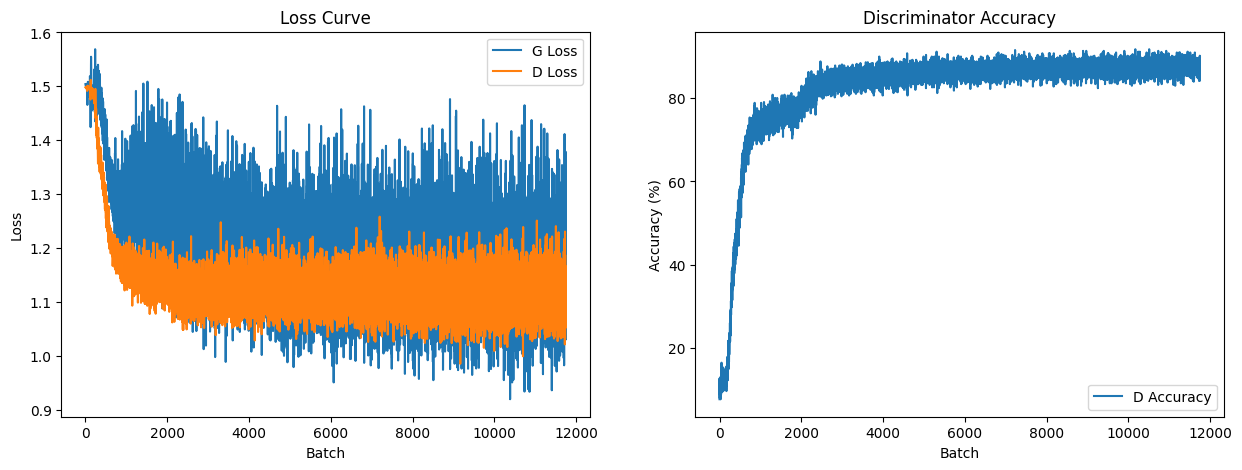

In [16]:
# --- Plotting Metrics ---
def plot_metrics(g_losses, d_losses, d_accuracies):
    plt.figure(figsize=(15, 5))

    # Generator and Discriminator Losses
    plt.subplot(1, 2, 1)
    plt.plot(g_losses, label="G Loss")
    plt.plot(d_losses, label="D Loss")
    plt.title("Loss Curve")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()

    # Discriminator Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(d_accuracies, label="D Accuracy")
    plt.title("Discriminator Accuracy")
    plt.xlabel("Batch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

plot_metrics(g_losses, d_losses, d_accuracies)

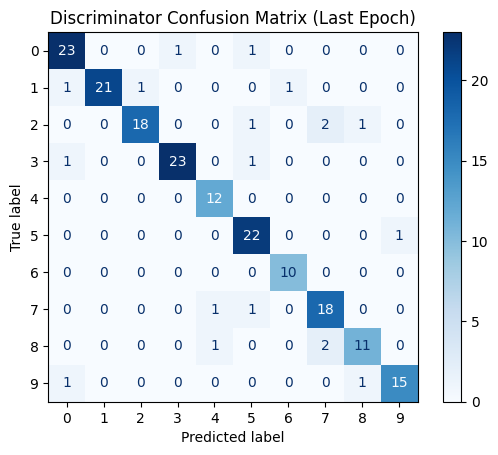

In [17]:
  def show_confusion_matrix(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(opt.n_classes))
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Discriminator Confusion Matrix (Last Epoch)")
    plt.show()

show_confusion_matrix(epoch_confusion_matrices[-1])

In [18]:
generator.eval()  # Set to evaluation mode
discriminator.eval()

test_dataset = datasets.MNIST(
    "../../data/mnist",
    train=False,  # Set train=False to load the test dataset
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
)


#Create the test DataLoader
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=opt.batch_size,
    shuffle=False,  # No need to shuffle the test dataset
)

# test_dataloader = DataLoader(
#     PoisonedMNIST(
#         "../../data/mnist",
#         train=True,
#         download=True,
#         transform=transforms.Compose(
#             [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
#         ),
#         poison_fraction=0.1,  # Inject 10% outliers
#         attack_type="label_flip"  # Flip labels as the attack
#     ),
#     batch_size=opt.batch_size,
#     shuffle=True,
# )
all_preds = []
all_labels = []
all_validities = []

with torch.no_grad():  # Disable gradient computation for faster performance
    for imgs, labels in test_dataloader:
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # Generate predictions from discriminator
        validity, pred_labels = discriminator(real_imgs)

        # Save predictions and actual labels for evaluation
        all_preds.append(pred_labels.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_validities.append(validity.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_validities = np.concatenate(all_validities, axis=0)


# Calculate accuracy
pred_classes = np.argmax(all_preds, axis=1)
accuracy = np.mean(pred_classes == all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Test Accuracy: 95.72%


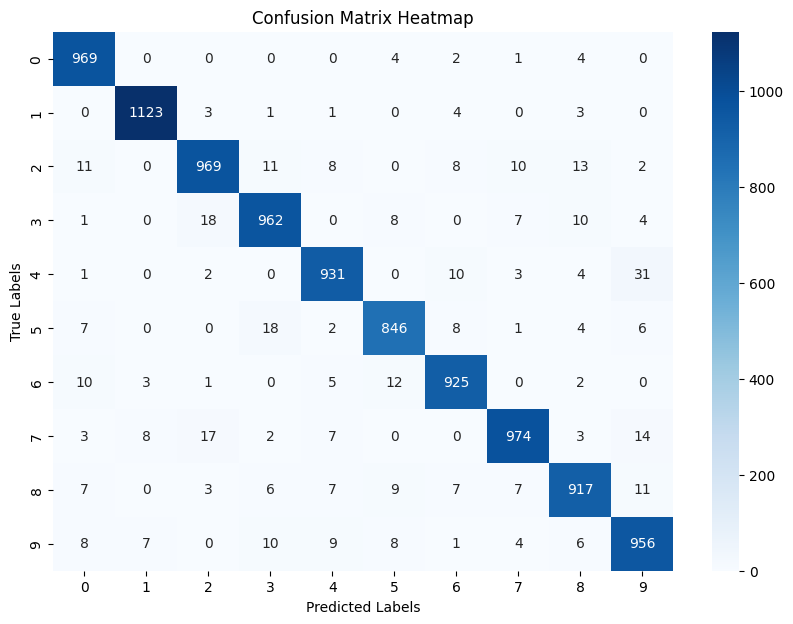

In [19]:
#For Heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_mat = confusion_matrix(all_labels, pred_classes)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


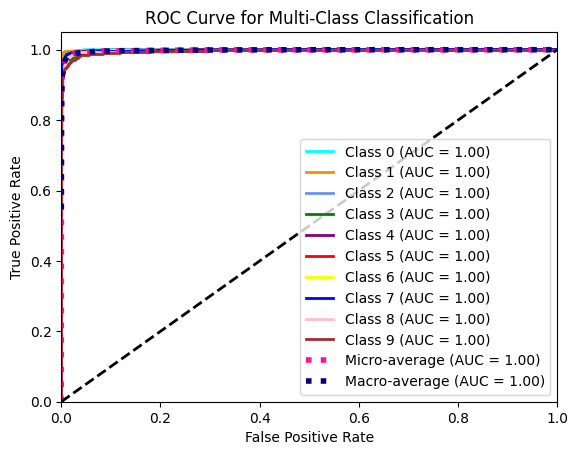

Micro-average AUC: 0.9983
Macro-average AUC: 0.9982


In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC curve calculation
n_classes = opt.n_classes
labels_binarized = label_binarize(all_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(labels_binarized.ravel(), all_preds.ravel())
micro_auc = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# Plot ROC curve for each class
plt.figure()
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "purple", "red", "yellow", "blue", "pink", "brown"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot micro and macro average ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4, label=f'Micro-average (AUC = {micro_auc:.2f})')
plt.plot(all_fpr, mean_tpr, color='navy', linestyle=':', linewidth=4, label=f'Macro-average (AUC = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()

print(f"Micro-average AUC: {micro_auc:.4f}")
print(f"Macro-average AUC: {macro_auc:.4f}")
